In [1]:
# univariate multi-step lstm
import pandas as pd
import numpy as np
from keras import backend as K
import scipy.stats as st
import kerastuner as kt
import tensorflow as tf
import glob
import json
from collections import defaultdict
from pandas import read_csv
from kerastuner.tuners import Hyperband
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import (LSTM, GRU, Dense, Flatten, RepeatVector, TimeDistributed, )
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.callbacks import ModelCheckpoint


In [2]:
df = read_csv("predicted_temperature_and_actual_values.csv").dropna()

In [3]:
df.drop_duplicates('pred_temperature')

,pred_temperature,temperature,humidity
0,23.770737,20.978495,27.376344
1,23.780455,23.768421,24.040602
2,23.788734,25.008850,30.794690
4,23.780457,23.854545,29.054545
95,23.788736,22.566667,23.933333
150,23.770735,22.983051,23.423729
267,23.770733,22.583333,20.050000


In [4]:
def calculate_confidence(data):
    diff_actual_pred = data.temperature - data.pred_temperature
    std = st.sem(diff_actual_pred.values.tolist())
    mean = diff_actual_pred.mean()
    N = diff_actual_pred.shape[0]-1
    confidence_interval= st.t.interval(0.9999, N, loc=mean, scale=std)
    return confidence_interval

In [5]:
interval = calculate_confidence(df)
print(interval, (interval[1] + interval[0])/2)

(-0.11872371577776746, 0.09642935775486981) -0.011147179011448821


n_input=3
dataset = read_csv("predicted_temperature_and_actual_values.csv")
# convert history into inputs and outputs
def to_supervised(dataset, n_input):
    gaussian_dataset = dataset.copy()
    mu, sigma = 0, 1 # mean and standard deviation
    s = np.random.normal(mu, sigma, gaussian_dataset['temperature'].shape[0])
    gaussian_dataset['temperature'] = gaussian_dataset['temperature'] + s

    # labeling datapoints
    all_dataset = pd.concat([gaussian_dataset, dataset])
    interval = [-0.5830552371205128, 0.5830552371205128] # Mean RMSE from forecasting CNN-LSTM model 
    diff_actual_pred = dataset.temperature - dataset.pred_temperature
    all_dataset['label'] = ((diff_actual_pred>=interval[0]) & (diff_actual_pred<=interval[1]))
    return all_dataset

In [6]:
def segemet_dataset(dataset, n_input):
    X = list()
    in_start = 0
    data = dataset.values
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        # ensure we have enough data for this instance
        if in_end <= len(data):
            x_input = data[in_start:in_end, 1]
            x_input[-1] = data[in_end-1, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
        # move along one time step
        in_start += 1
    return np.array(X).astype('float32').reshape((-1,1,n_input))

In [7]:
def add_gaussian(dataset, ascending:bool):
    mu, sigma = 0, 1 # mean and standard deviation
    for i in range(dataset.shape[2]):
        s = np.abs(np.random.normal(mu, sigma, dataset.shape[0]))
        if ascending:
            s = -1 * s
        dataset[:,:, :i] = dataset[:,:, :i] + s.reshape(-1, 1, 1)

In [8]:
n_input=3
# convert history into inputs and outputs
def to_supervised(normal_dataset, n_input):
    ascending_dataset = normal_dataset.copy()
    descending_dataset = normal_dataset.copy()
    normal_segments = segemet_dataset(normal_dataset,n_input)
    ascending_segments = segemet_dataset(ascending_dataset.sort_values('temperature', ascending=True),n_input)
    descending_segments = segemet_dataset(descending_dataset.sort_values('temperature', ascending=False),n_input)
    add_gaussian(ascending_segments, True)
    add_gaussian(descending_segments, False)
    df_normal_segments = pd.DataFrame({'pred_temperature': list(normal_segments)})
    df_ascending_segments = pd.DataFrame({'pred_temperature': list(ascending_segments)})
    df_descending_segments = pd.DataFrame({'pred_temperature': list(descending_segments)})
    df_normal_segments['label'] = True
    df_ascending_segments['label'] = False
    df_descending_segments['label'] = False
    return pd.concat([df_normal_segments, df_ascending_segments, df_descending_segments]).sample(frac=1).reset_index()

In [9]:
to_supervised(df, n_input)

,index,pred_temperature,label
0,420,"[[23.770737, 23.780457, 23.788734]]",True
1,394,"[[26.089529, 24.501171, 23.780457]]",False
2,398,"[[23.911533, 23.8288, 23.770737]]",False
3,271,"[[22.494286, 23.31044, 23.780457]]",False
4,127,"[[23.009266, 23.469608, 23.780457]]",False
...,...,...,...
2311,73,"[[25.914986, 24.789673, 23.788734]]",False
2312,95,"[[20.402866, 21.7448, 23.770737]]",False
2313,308,"[[23.788734, 23.770737, 23.780457]]",True
2314,72,"[[23.770737, 23.780457, 23.788734]]",True


In [10]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    split_index = int((len(data)*0.8))
    train, test = data[:split_index], data[split_index:]
    return train, test

In [11]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
# train the model
def build_cnn_model(hp):
    # define hyperparameters parameters
    interval_size = hp.Int('interval_size', 1, 7, step=2)
    num_layers = hp.Int('num_layers', 1, 7, step=2, default=1)
    activation = hp.Choice("activation", ["sigmoid", "relu", "tanh"], default="sigmoid")
    hiddent_units = hp.Choice('hiddent_units', [50, 100, 150, 200], default=200)

    n_features, n_outputs = interval_size, 2
    n_timesteps = 1

    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(n_timesteps, n_features)))
    #model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(RepeatVector(n_features))
    # we want sigmoid in the first lstm layer so that we convert the data between 0 and 1
    model.add(LSTM(hiddent_units, return_sequences=num_layers > 1))
    for i in range(num_layers - 2):
        model.add(LSTM(hiddent_units, activation=activation, return_sequences=True, dropout=hp.Float("dropout", 0.0 , 0.8 , 0.2, default=0)))
    if num_layers > 1:
        model.add(LSTM(hiddent_units, activation=activation))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', metrics=['accuracy', recall_m, precision_m, f1_score], optimizer='adam')
    return model

In [13]:
def build_lstm_model(hp):
    # define hyperparameters parameters
    interval_size = hp.Int('interval_size', 1, 7, step=2)
    num_layers = hp.Int('num_layers', 1, 7, step=2, default= 1)
    activation = hp.Choice("activation", ["sigmoid", "relu", "tanh"], default= "relu")
    hiddent_units = hp.Choice('hiddent_units', [50, 100, 150, 200], default= 200)
    n_features, n_outputs = interval_size, 2
    n_timesteps = 1

    # define model
    model = Sequential()
    # we want sigmoid in the first layer so that we convert the data between 0 and 1
    model.add(LSTM(hiddent_units, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=num_layers > 1))
    for i in range(num_layers - 2):
        model.add(LSTM(hiddent_units, activation=activation, return_sequences=True, dropout=hp.Float("dropout", 0.0 , 0.8 , 0.2, default= 0)))
    if num_layers > 1:
        model.add(LSTM(hiddent_units, activation=activation))
    model.add(Dense(200))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', metrics=['accuracy',f1_score], optimizer='adam')
    return model

In [14]:
def build_gru_model(hp):
    # define hyperparameters parameters
    interval_size = hp.Choice('interval_size', [3, 5, 7, 9, 11])
    num_layers = hp.Int('num_layers', 1, 7, step=2, default=1)
    activation = hp.Choice("activation", ["sigmoid", "relu", "tanh"], default="tanh")
    hiddent_units = hp.Choice('hiddent_units', [50, 100, 150, 200], default=100)
    n_features, n_outputs = interval_size, 2
    n_timesteps = 1

    # define model
    model = Sequential()
    # we want sigmoid in the first layer so that we convert the data between 0 and 1
    model.add(GRU(hiddent_units, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=num_layers > 1))
    for i in range(num_layers - 2):
        model.add(GRU(hiddent_units, activation=activation, return_sequences=True, dropout=hp.Float("dropout", 0.0 , 0.8 , 0.2, default=0)))
    if num_layers > 1:
        model.add(GRU(hiddent_units, activation=activation))
    model.add(Dense(200))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', metrics=['accuracy', f1_score], optimizer='adam')
    return model

In [15]:
# decision tree model
def build_model_decision_tree(hp):
    decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
    return decision_tree

In [16]:
#s = to_supervised(df, 3).groupby(['temperature', 'label']).count().reset_index()
#s[s['humidity'] > 0][s['temperature'] == 23].sort_values(['temperature']).tail(30)
#df = df.drop_duplicates(subset=['pred_temperature'])

In [17]:
train, test = split_dataset(df)
df_train = to_supervised(train, n_input)
train_x = np.asarray(df_train['pred_temperature'].values.tolist())
train_y = df_train['label'].values.astype('float32')
df_test = to_supervised(test, n_input)
test_x = np.asarray(df_test['pred_temperature'].values.tolist())
test_y = df_test['label'].values.astype('float32')
train_y = to_categorical(train_y, num_classes=2)
val_y = to_categorical(test_y, num_classes=2)
#print(train_x, pd.DataFrame(train_y).groupby(0).count())
#print(test_x, pd.DataFrame(val_y).groupby(0).count())
df_train.groupby('label').count()

,index,pred_temperature
label,,
False,1234,1234
True,617,617


In [18]:
np.asarray(train_x.tolist()).shape

(1851, 1, 3)

In [19]:
class MyTuner(Hyperband):
    def  _build_and_fit_model(self, trial, fit_args, fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        if 'callbacks' in fit_kwargs:
            fit_kwargs['callbacks'] = [cb for cb in fit_kwargs['callbacks'] if not isinstance(cb, ModelCheckpoint)]
        return model.fit(*fit_args, **fit_kwargs)

In [20]:
tuner = MyTuner(build_cnn_model,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='fault_classification_evaluation',
                     project_name='cnn-lstm',
                     overwrite=True)

In [21]:
tuner.search(train_x, train_y,
             validation_split=0.2, callbacks=[])


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
interval_size     |5                 |?                 
num_layers        |3                 |?                 
activation        |relu              |?                 
hiddent_units     |150               |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |3                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2


ValueError: in user code:

    C:\Users\ayads\Anaconda3\envs\DT005A Final Project\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\ayads\Anaconda3\envs\DT005A Final Project\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ayads\Anaconda3\envs\DT005A Final Project\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ayads\Anaconda3\envs\DT005A Final Project\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ayads\Anaconda3\envs\DT005A Final Project\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ayads\Anaconda3\envs\DT005A Final Project\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\ayads\Anaconda3\envs\DT005A Final Project\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\ayads\Anaconda3\envs\DT005A Final Project\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\ayads\Anaconda3\envs\DT005A Final Project\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 5 but received input with shape [None, 1, 3]


In [22]:
# Print summary for same 
hyperparameter_results = defaultdict(list)
for file in glob.glob("fault_classification_evaluation/lstm/trial*/trial.json"):
    trial = json.load(open(file))
    if trial['status'] == 'COMPLETED' and trial['score'] is not None:
        hyperparameter_results[trial['trial_id'] + str(trial["hyperparameters"]["values"])].append(trial['metrics']['metrics']["val_f1_score"]['observations'][0]['value'][0])

for param, f1_scores in sorted(hyperparameter_results.items(), key=lambda a: sum(a[1]), reverse=True):
    mean_f1_score = sum(f1_scores)/len(f1_scores)
    max_f1_score = max(f1_scores)
    min_f1_score = min(f1_scores)
    variance_f1_score = (sum([(mean_f1_score-current_score)**2 for current_score in f1_scores]))/len(f1_scores)
    std_dev_f1_score = variance_f1_score ** (1/2)
    # summarize scores
    print("-----------------------------------------")
    print("hyperparameter tune",param)
    print("mean_f1_score",mean_f1_score)
    print("max_f1_score",max_f1_score)
    print("min_f1_score",min_f1_score)
    print("variance_f1_score",variance_f1_score)
    print("std_dev_f1_score",std_dev_f1_score)
    break

-----------------------------------------
hyperparameter tune 01efc999a8e4d0ae80cf5250dbeb3241{'num_layers': 5, 'activation': 'relu', 'hiddent_units': 100, 'dropout': 0.6000000000000001, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
mean_f1_score 0.7799478769302368
max_f1_score 0.7799478769302368
min_f1_score 0.7799478769302368
variance_f1_score 0.0
std_dev_f1_score 0.0


In [23]:
## Kör det här!!!  
# load the new file
# split into train and test
algorithm_f1_score_list = []
algorithm_std_f1_score_list = []

algorithm_accuracy_score_list = []
algorithm_std_accuracy_score_list = []

algorithms = {
    'LSTM': build_lstm_model,
    'CNN-LSTM': build_cnn_model,
    'GRU': build_gru_model
}

for algorithm, build_model in algorithms.items():
    print("--------------------------------------")
    print("algorithm",algorithm)
    #train, test = split_dataset(df)
    #df_train = to_supervised(train, n_input)
    #df_test = to_supervised(test, n_input)
    
    # evaluate model and get scores
    # mean, maximum,minimum,std_dev,
    f1_scores = []
    accuracy_scores = []
    for i in range(10):
        hp = kt.HyperParameters()
        interval_size = hp.Fixed('interval_size', value=n_input)
        model = build_model(hp)
        epochs = 10
        batch_size = 32

        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=False, callbacks=[callback])
        metrics = model.evaluate(test_x, val_y, return_dict=True, verbose=True)
        f1_scores.append(metrics['f1_score'])
        accuracy_scores.append(metrics['accuracy'])
    
    # Prepare and calculate results
    # F1-scores
    mean_f1_score = sum(f1_scores)/len(f1_scores)
    max_f1_score = max(f1_scores)
    min_f1_score = min(f1_scores)
    variance_f1_score = (sum([(mean_f1_score-current_score)**2 for current_score in f1_scores]))/len(f1_scores)
    std_dev_f1_score = variance_f1_score ** (1/2.0)
    # Accuracy
    mean_accuracy_score = sum(accuracy_scores)/len(accuracy_scores)
    max_accuracy_score = max(accuracy_scores)
    min_accuracy_score = min(accuracy_scores)
    variance_accuracy_score = (sum([(mean_accuracy_score-current_score)**2 for current_score in accuracy_scores]))/len(accuracy_scores)
    std_dev_accuracy_score = variance_accuracy_score ** (1/2.0)
    # Add values to list
    algorithm_f1_score_list.append(mean_f1_score)
    algorithm_std_f1_score_list.append(std_dev_f1_score)
    algorithm_accuracy_score_list.append(mean_accuracy_score)
    algorithm_std_accuracy_score_list.append(std_dev_accuracy_score)
    # summarize f1-scores
    print("f1_scores", f1_scores)
    print("mean_f1_score",mean_f1_score)
    print("max_f1_score",max_f1_score)
    print("min_f1_score",min_f1_score)
    print("variance_f1_score",variance_f1_score)
    print("std_dev_f1_score",std_dev_f1_score)
    # Accuracy score
    print("accuracy_scores", accuracy_scores)
    print("mean_accuracy_score",mean_accuracy_score)
    print("max_accuracy_score",max_accuracy_score)
    print("min_accuracy_score",min_accuracy_score)
    print("variance_accuracy_score",variance_accuracy_score)
    print("std_dev_accuracy_score",std_dev_accuracy_score)
    # summarize_scores('cnn-lstm', mean_score, scores)

--------------------------------------
algorithm LSTM
15/15 [==============================] - 0s 1ms/step - loss: 0.1530 - accuracy: 0.6667 - f1_score: 0.6653
f1_scores [0.9481631517410278, 0.883951723575592, 0.963326632976532, 0.6653408408164978, 0.6653408408164978, 0.6653408408164978, 0.6653408408164978, 0.9813732504844666, 0.9369493126869202, 0.6653408408164978]
mean_f1_score 0.8040468275547028
max_f1_score 0.9813732504844666
min_f1_score 0.6653408408164978
variance_f1_score 0.0197828848328783
std_dev_f1_score 0.14065164354844312
accuracy_scores [0.9564270377159119, 0.8845316171646118, 0.9694989323616028, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 0.984749436378479, 0.9411764740943909, 0.6666666865348816]
mean_accuracy_score 0.8069716930389405
max_accuracy_score 0.984749436378479
min_accuracy_score 0.6666666865348816
variance_accuracy_score 0.020281086894029843
std_dev_accuracy_score 0.14241168103084045
--------------------------------------
alg

In [24]:
np.argmax(model.predict(test_x), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

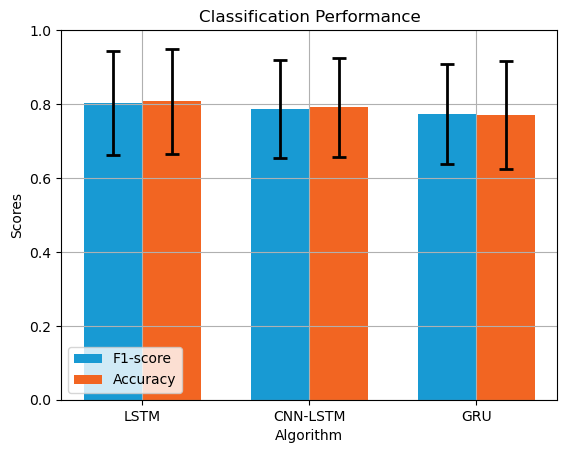

In [25]:
# plot scores
x = np.arange(len(algorithms.keys()))
width = 0.35
pyplot.rcdefaults()
fig, ax = pyplot.subplots()

f1_score_bar = ax.bar(x - width/2, algorithm_f1_score_list, width,yerr=algorithm_std_f1_score_list, align='center', color='#189ad3', label='F1-score', error_kw=dict(ecolor="black", lw=2, capsize=5, capthick=2))
accuracy_score_bar = ax.bar(x + width/2, algorithm_accuracy_score_list, width, yerr=algorithm_std_accuracy_score_list, align='center', color='#f26522', label='Accuracy', error_kw=dict(ecolor="black", lw=2, capsize=5, capthick=2))
ax.set_xticks((0,1,2))
ax.set_ylabel('Scores')
ax.set_xlabel('Algorithm')
ax.set_xticklabels(algorithms.keys())
ax.set_title('Classification Performance')
ax.legend()
pyplot.rc('lines')
pyplot.grid(True)
pyplot.ylim([0, 1])
pyplot.savefig('classification_result.png', bbox_inches='tight')
pyplot.show()

In [28]:
hp = kt.HyperParameters()
interval_size = hp.Fixed('interval_size', value=n_input)
model = build_cnn_model(hp)
epochs = 10
batch_size = 32
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=False, callbacks=[callback])

In [37]:
model.save('classification-cnn-lstm-model.h5')

In [34]:
model.save_weights('classification-cnn-lstm-weights.h5')
with open('classification-cnn-lstm-config.yaml', 'w') as f:
    f.write(model.to_yaml())

In [36]:
from keras.models import

NameError: name 'keras' is not defined